In [1]:
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import torchvision
import numpy as np

from models import Generator
from models import Discriminator
from utils import ReplayBuffer
from utils import weights_init_normal
import os

import time
start_time = time.time()

In [2]:
if not os.path.exists('ckpt'):
    os.makedirs('ckpt')

# parameters
#TODO : set up all the parameters
epochs = 20    # number of epochs of training
batchsize = 50    # size of the batches
animation_root = '../animation'    # root directory of the dataset
cartoon_root = '../cartoon'    # root directory of the dataset
lr = 0.0002    # initial learning rate
size = 32    # size of the data crop (squared assumed)
input_nc = 3    # number of channels of input data
output_nc = 3    # number of channels of output data

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

/home/phua/Pelajaran/deep_learning/Homework3/number2/utils.py:44: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [5]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [6]:
# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

In [7]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
input_A = Tensor(batchsize, input_nc, size, size)
input_B = Tensor(batchsize, output_nc, size, size)
target_real = Variable(Tensor(batchsize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchsize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [8]:
# Dataset loader
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
animation_set = torchvision.datasets.ImageFolder(animation_root, transform) 
cartoon_set = torchvision.datasets.ImageFolder(cartoon_root, transform) 
animation_loader = torch.utils.data.DataLoader(dataset=animation_set,batch_size=batchsize,shuffle=True)
cartoon_loader = torch.utils.data.DataLoader(dataset=cartoon_set,batch_size=batchsize,shuffle=True)

In [9]:
###################################
G_loss  = []
DA_loss  = []
DB_loss  = []
###### Training ######
for epoch in range(1, epochs):
    i=1
    print('epoch',epoch)
    for batch in zip(animation_loader, cartoon_loader):
        # Set model input
        A = torch.FloatTensor(batch[0][0])
        B = torch.FloatTensor(batch[1][0])
        real_A = Variable(input_A.copy_(A))
        real_B = Variable(input_B.copy_(B))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        ######################################################################
        # TODO : calculate the loss for the generators, and assign to loss_G
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        ######################################################################
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()
        ######################################################################
        # TODO : calculate the loss for a discriminator, and assign to loss_D_A
        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        ######################################################################

        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()
        ######################################################################
        # TODO : calculate the loss for the other discriminator, and assign to loss_D_B
        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        ######################################################################
        
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
        
        G_loss.append(loss_G.item())
        DA_loss.append(loss_D_A.item())
        DB_loss.append(loss_D_B.item())
        # Progress report
        if (i%100==0):
            print("loss_G : ",loss_G.data.cpu().numpy() ,",loss_D:", (loss_D_A.data.cpu().numpy() + loss_D_B.data.cpu().numpy()))
            i=0
        i=i+1
    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), 'ckpt/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'ckpt/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'ckpt/netD_A.pth')
    torch.save(netD_B.state_dict(), 'ckpt/netD_B.pth')
    
end_time = time.time()
print('Total cost time',time.strftime("%H hr %M min %S sec", time.gmtime(end_time - start_time)))

epoch 1


/home/phua/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss_G :  7.137564 ,loss_D: 0.34190774
loss_G :  6.2933993 ,loss_D: 0.362305
epoch 2
loss_G :  5.8380847 ,loss_D: 0.31689668
loss_G :  5.85699 ,loss_D: 0.27226377
epoch 3
loss_G :  6.057973 ,loss_D: 0.36689314
loss_G :  5.1620865 ,loss_D: 0.30803746
epoch 4
loss_G :  5.3022013 ,loss_D: 0.3198412
loss_G :  4.7039814 ,loss_D: 0.36451176
epoch 5
loss_G :  5.3769407 ,loss_D: 0.31125778
loss_G :  4.828934 ,loss_D: 0.41668677
epoch 6
loss_G :  4.770818 ,loss_D: 0.34762827
loss_G :  4.243789 ,loss_D: 0.51793087
epoch 7
loss_G :  4.771199 ,loss_D: 0.305318
loss_G :  4.4907694 ,loss_D: 0.31449252
epoch 8
loss_G :  4.2841616 ,loss_D: 0.45857388
loss_G :  4.327481 ,loss_D: 0.28988713
epoch 9
loss_G :  4.6738067 ,loss_D: 0.30930358
loss_G :  4.514515 ,loss_D: 0.26865143
epoch 10
loss_G :  4.9134393 ,loss_D: 0.34708083
loss_G :  4.13366 ,loss_D: 0.35560793
epoch 11
loss_G :  4.2707515 ,loss_D: 0.3620999
loss_G :  4.2822504 ,loss_D: 0.2890925
epoch 12
loss_G :  4.592839 ,loss_D: 0.4150443
loss_G :  

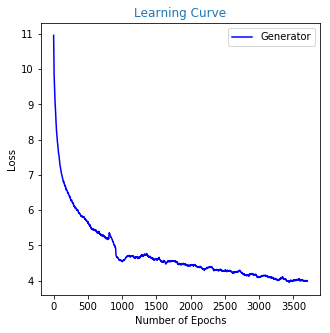

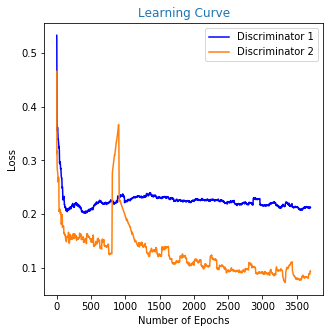

In [11]:
# TODO : plot the figure
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

N = 100
G_loss = running_mean(G_loss, N)
DA_loss = running_mean(DA_loss, N)
DB_loss = running_mean(DB_loss, N)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Learning Curve'.format('default'), color='C0')
ax.set_ylabel('Loss')
ax.set_xlabel('Number of Epochs')
ax.plot(list(i+1 for i in range(len(G_loss))), G_loss, 'b', label='Generator')
ax.legend()

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Learning Curve'.format('default'), color='C0')
ax.set_ylabel('Loss')
ax.set_xlabel('Number of Epochs')
ax.plot(list(i+1 for i in range(len(DA_loss))), DA_loss, 'b', label='Discriminator 1')
ax.plot(list(i+1 for i in range(len(DB_loss))), DB_loss, 'tab:orange', label='Discriminator 2')
ax.legend()